### Testing PAR-2 alleles with a combination of point mutations in the RING domain

In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd

from src import add_stats_table_row, bootstrap_effect_size_pd, bounded_mean_1d, dataplot

%matplotlib inline

mpl.rcParams["figure.dpi"] = 150

if not os.path.exists("Figs"):
    os.mkdir("Figs")

### Quantification

In [2]:
df = pd.read_csv("../../../data/par2_nebd_embryos.csv")
df_quantification = pd.read_csv("../../../data/par2_nebd_quantification.csv")
df_quantification_grouped = df_quantification.groupby("EmbryoID")

_dfs = []
for i, r in df_quantification_grouped:
    cyt = np.mean(r["Cytoplasmic signal"])
    mem_tot = np.mean(r["Membrane signal"])
    mem_ant = bounded_mean_1d(r["Membrane signal"], [0.4, 0.6])
    mem_post = bounded_mean_1d(r["Membrane signal"], [0.9, 0.1])
    ratio_post = mem_post / cyt
    p = {
        "EmbryoID": i,
        "Cyt": cyt,
        "Mem_tot": mem_tot,
        "Mem_ant": mem_ant,
        "Mem_post": mem_post,
        "Ratio post": ratio_post,
    }
    _dfs.append(pd.DataFrame(p, index=[i]))
df_summary = pd.concat(_dfs)
df = pd.merge(df, df_summary, on="EmbryoID")

# Filter
df = df[df.Line.isin(["lp637", "nwg240", "nwg338", "nwg400", "nwg407", "nwg351"])]

# Add genotype column
genotype_dict = {
    "lp637": "WT",
    "nwg240": "C56S",
    "nwg338": "L109R",
    "nwg400": "L50R",
    "nwg407": "C56S+L109R",
    "nwg351": "L50R+L109R",
}
df["Genotype"] = [genotype_dict[a] for a in df["Line"]]

### Figure

/usr/local/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


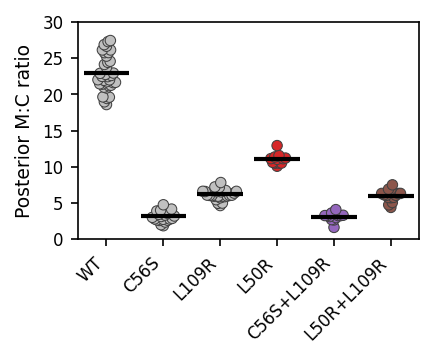

In [3]:
_df = df[df.RNAi == "wt"]

# Set up figure
fig, ax = plt.subplots(figsize=(15, 2.5))
offset = lambda p: transforms.ScaledTranslation(p / 72.0, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

# Color pallete
order = ["WT", "C56S", "L109R", "L50R", "C56S+L109R", "L50R+L109R"]
colors = ["silver", "silver", "silver", "tab:red", "tab:purple", "tab:brown"]

# Plot data
dataplot(
    data=_df,
    x="Genotype",
    y="Ratio post",
    ax=ax,
    order=order,
    linewidth=0.5,
    palette=colors,
    width=0.8,
    linewidth_mean=2,
    transform=trans + offset(0),
)

# Finalise figure
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")

ax.tick_params(axis="both", labelsize=8)
ax.set_xlabel("")
ax.set_ylim(0, 30)
ax.set_ylabel("Posterior M:C ratio", fontsize=9)
fig.set_size_inches(3.5, 2.5)
fig.subplots_adjust(left=0.25, bottom=0.3)
fig.savefig("Figs/mcr.png", dpi=600, transparent=True)

In [4]:
# Effect size L50R vs WT
es = bootstrap_effect_size_pd(data=_df, x="Genotype", y="Ratio post", a="WT", b="L50R")
add_stats_table_row(
    figure="S4",
    panel="B",
    sample_a="PAR-2(WT)",
    sample_b="PAR-2(L50R)",
    measure="Posterior M:C ratio",
    comparisons=es,
    key="AdvyF5RinK",
)

# Effect size C56S+L109R vs C56S
es = bootstrap_effect_size_pd(
    data=_df, x="Genotype", y="Ratio post", a="C56S", b="C56S+L109R"
)
add_stats_table_row(
    figure="S4",
    panel="B",
    sample_a="PAR-2(C56S)",
    sample_b="PAR-2(C56S,L109R)",
    measure="Posterior M:C ratio",
    comparisons=es,
    key="wQhVJSlKeD",
)

# Effect size L50R+L109R vs L109R
es = bootstrap_effect_size_pd(
    data=_df, x="Genotype", y="Ratio post", a="L109R", b="L50R+L109R"
)
add_stats_table_row(
    figure="S4",
    panel="B",
    sample_a="PAR-2(L109R)",
    sample_b="PAR-2(L50R,L109R)",
    measure="Posterior M:C ratio",
    comparisons=es,
    key="j4t0Gvbi0v",
)